# Project Overlord: Movie Predictor
### This project is dedicated to the legendary action hero Steven Seagal.
![title](steven.jpg)
## What does it do?
### Predict
- Average rating of movies on IMDb

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

headers = [
        "title",
        "rating",
        "Year",
        "runtime",
        "Mpa",
        "raters",
        "budget",
        #"gross USA Ca gross_US_CA,
        "gross",
        "color",
        "meta score",
        "Director",
        "Writer",
        "main Actor",
        "second Actor",
        "genre",
    ]


In [3]:
start = 1
pages = 10
links = []

for i in range(pages):
    url = f"https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&count=100&start={start}&ref_=adv_nxt"
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)
    search1 = soup.find_all(class_="lister-item-index unbold text-primary")
    link_list = [i.findNext().findChildren()[0]["href"] for i in search1]
    links.extend(link_list)
    start += 100

In [4]:
class IMDBScraper:


   def __init__(self, url):

       self.url = url

       self.download_page()

   def download_page(self):

       # method for downloading the hotel page

       self.page = requests.get(self.url).text

   def scrape_data(self):

       #method for scraping out movie title and description

       soup = BeautifulSoup(self.page, "html.parser")
    #Title
       movie_title = soup.find("h1", {"data-testid": "hero-title-block__title"}).text
    #Rating
       try:
            rating = float(soup.find('div', {"data-testid": "hero-rating-bar__aggregate-rating__score"}).text.strip().replace("/10",""))
       except:
            rating = np.nan
            print(movie_title, " didn't have rating")
    #Raters
       raters = soup.find('div', {"data-testid": "hero-rating-bar__aggregate-rating"}).text.split("/")[1]

       if len(raters.replace("M", "")) < len(raters):
        raters = int(float(raters.replace("M", ""))*1000000)
       elif len(raters.replace("K", "")) < len(raters):
        raters = int(float(raters.replace("K", ""))*1000)
    #Gross US and Canada
       try:
        gross_US_CA = int(soup.find('li', {"data-testid": "title-boxoffice-grossdomestic"}).text.strip().replace("$", "").replace(",", "").replace("Gross US & Canada", ""))
       except:
        gross_US_CA = np.nan
    #Gross World wide
       try:
        gross = int(soup.find('li', {"data-testid": "title-boxoffice-cumulativeworldwidegross"}).text.strip().replace("$", "").replace(",", "").replace("Gross worldwide", ""))
       except:
        gross = np.nan
       
    #Release year, Mpa
       yearMpa = soup.find('ul', {"data-testid": "hero-title-block__metadata"}).text
       
       releaseYear = int(yearMpa[0:4:1])

       if len(yearMpa) == 14: #check if Mpa info is avilable
        Mpa = np.nan
       elif yearMpa[9] == 'R': #check if movie is rated R
        Mpa = 18
       elif yearMpa[9] == '-': #check if mpa is -M
        Mpa = np.nan
       elif yearMpa[8] == 'P': #check if movie is rated PG\n",
        Mpa = 13
       elif len(yearMpa) == 16: #check if Mpa is than age 10\n",
        Mpa = yearMpa[9]
       else:
        Mpa = yearMpa[10:12:1]

    #runtime
       runtime = soup.find('li', {"data-testid":"title-techspec_runtime"}).text.replace("Runtime", "").replace("hours ", "").replace("hour ", "").replace("hours", "").replace(" minutes", "")
       
       hoursMinutes = runtime.split(" ")
       try:
        minutes = int(hoursMinutes[0])*60 + int(hoursMinutes[1])
       except:
        minutes = np.nan
        print(movie_title, " didn't have runtime") 
        
    #Budget
       try:
           budget = int(soup.find('li', {"data-testid": "title-boxoffice-budget"}).text.strip().replace("$", "").replace("(estimated)", "").replace("Budget", "").replace(",", ""))

       except:
           budget = np.nan
    #Color
       try:
        color = soup.find('li', {"data-testid": "title-techspec_color"}).text.strip()
       except:
        color = "ColorColor"
    #Meta Score
       try:
          meta_score = int(soup.find('span', {"class" : "score-meta"}).text.strip())
       except:
          meta_score = np.nan
   
   #Genre
       genre = soup.find("div", {"data-testid": "genres"}).find("span", class_ = "ipc-chip__text").text
       
   #Director
       director = soup.find('section', {"data-testid" : "title-cast"}).find('a', class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text

      
   #Writer
       try:
        writer = soup.find('section', {"data-testid" : "title-cast"}).find('a', class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").find_next().text.strip().replace("Writers", "").replace("Writer", "").split("(")[0]
       except:
        writer = soup.find('section', {"data-testid" : "title-cast"}).find('a', class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").find_next().text.strip().replace("Writers", "").replace("Writer", "")
   #1st Actor
       firstActor = soup.find('a', {"data-testid" : "title-cast-item__actor"}).text

   #2st Actor
       secondActor = soup.find('div', {"data-testid" : "title-cast-item"}).find_next('div', {"data-testid" : "title-cast-item"}).find('a', {"data-testid" : "title-cast-item__actor"}).text
    
   
       return {"title": movie_title,

               "rating" : rating,

               "Year" : releaseYear,

               "runtime" : minutes,

               "Mpa" : Mpa,

               "raters" : raters,

               "budget" : budget,

               #"gross USA Canada" : gross_US_CA,

               "gross" : gross,

               "color" : color,

               "meta score" : meta_score,

               "Director" : director,

               "Writer" : writer,

               "main Actor" : firstActor,

               "second Actor" : secondActor,

               "genre" : genre,

               }


In [5]:

movieInfo = pd.DataFrame(columns=headers)
counter = 0

for url in links:
   counter+=1
   url = "https://www.imdb.com" + url
   x = IMDBScraper(url)

   df = pd.DataFrame([x.scrape_data()], columns=headers)

   movieInfo = pd.concat([movieInfo,df[headers]], join='outer', ignore_index=True)
   print(counter/len(links), "%")


0.001 %
0.002 %
0.003 %
0.004 %
0.005 %
0.006 %
0.007 %
0.008 %
0.009 %
0.01 %
0.011 %
0.012 %
0.013 %
0.014 %
0.015 %
0.016 %
0.017 %
0.018 %
0.019 %
0.02 %
0.021 %
0.022 %
0.023 %
0.024 %
0.025 %
0.026 %
0.027 %
0.028 %
0.029 %
0.03 %
0.031 %
0.032 %
0.033 %
0.034 %
0.035 %
0.036 %
0.037 %
0.038 %
0.039 %
0.04 %
0.041 %
0.042 %
0.043 %
0.044 %
0.045 %
0.046 %
0.047 %
0.048 %
0.049 %
0.05 %
0.051 %
0.052 %
0.053 %
0.054 %
0.055 %
0.056 %
0.057 %
0.058 %
0.059 %
0.06 %
0.061 %
0.062 %
0.063 %
0.064 %
0.065 %
0.066 %
0.067 %
0.068 %
0.069 %
0.07 %
0.071 %
0.072 %
0.073 %
0.074 %
0.075 %
0.076 %
Old Boy - Hämnden  didn't have runtime
0.077 %
0.078 %
0.079 %
0.08 %
0.081 %
0.082 %
0.083 %
0.084 %
0.085 %
0.086 %
0.087 %
0.088 %
0.089 %
0.09 %
0.091 %
0.092 %
0.093 %
0.094 %
0.095 %
0.096 %
0.097 %
0.098 %
0.099 %
0.1 %
0.101 %
0.102 %
0.103 %
0.104 %
0.105 %
0.106 %
0.107 %
0.108 %
0.109 %
0.11 %
0.111 %
0.112 %
0.113 %
0.114 %
0.115 %
0.116 %
0.117 %
0.118 %
0.119 %
0.12 %
0.121 %
0.122 

In [6]:
movieInfo.dropna( inplace=True)
movieInfo.reset_index(inplace=True,drop=True)
movieInfo.to_csv("../movieInfoUprising.tsv", sep="\t")

#### Now the data is collected and ready to be transformed

In [66]:
# Read the collected data
movieInfo = pd.read_csv('../movieInfoUprising.tsv', delimiter='\t', usecols=headers)
movieInfo.drop('Mpa', axis=1, inplace=True)

cols = ["color" ,"Director", "Writer", "main Actor", "second Actor", "genre"]

movieInfoNew = movieInfo

colorDummies = pd.get_dummies(movieInfoNew["color"])
directorDummies = pd.get_dummies(movieInfoNew["Director"])
writerDummies = pd.get_dummies(movieInfoNew["Writer"])
mainActorDummies = pd.get_dummies(movieInfoNew["main Actor"])
secondActorDummies = pd.get_dummies(movieInfoNew["second Actor"])
genreDummies = pd.get_dummies(movieInfoNew["genre"])

movieInfoNew.drop(cols, axis=1, inplace=True)
movieInfoNew.drop('title', axis=1, inplace=True)

movieInfoNew = pd.merge(movieInfoNew, colorDummies, left_index=True, right_index=True)
movieInfoNew = pd.merge(movieInfoNew, directorDummies, left_index=True, right_index=True)
movieInfoNew = pd.merge(movieInfoNew, writerDummies, left_index=True, right_index=True)
movieInfoNew = pd.merge(movieInfoNew, mainActorDummies, left_index=True, right_index=True)
movieInfoNew = pd.merge(movieInfoNew, secondActorDummies, left_index=True, right_index=True)
movieInfoNew = pd.merge(movieInfoNew, genreDummies, left_index=True, right_index=True)


C:\Users\filip\AppData\Local\Temp/ipykernel_26652/2637820483.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Orson Welles_x', 'Clint Eastwood_x', 'Woody Allen_x', 'Sean Penn_x'} in the result is deprecated and will raise a MergeError in a future version.
  movieInfoNew = pd.merge(movieInfoNew, secondActorDummies, left_index=True, right_index=True)


In [71]:
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.decomposition import PCA

x_train, x_test = train_test_split(movieInfoNew, test_size=0.2)

y_train = x_train['rating']
y_test = x_test['rating']

x_train.drop('rating', axis=1, inplace=True)
x_test.drop('rating', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

from sklearn.decomposition import PCA
pca=PCA(n_components=8)
pca.fit(x_test)
x_test=pca.transform(x_test)

pca.fit(x_train)
x_train=pca.transform(x_train)
#let's check the shape of X_pca array
# print("shape of X_pca", x_test.shape)

# import numpy as np
# import matplotlib.pyplot as plt

In [23]:
x_train

array([[-1.93686063e+08,  9.72523557e+06, -1.47652583e+06,
        -2.53202366e+01,  1.09714321e+01],
       [ 2.62322178e+08, -2.55824553e+07,  7.97483942e+07,
         7.10307983e+00,  1.83385307e-01],
       [-2.12193122e+08, -1.26187058e+06, -9.70270451e+06,
        -1.78212173e+01, -2.31104974e+01],
       ...,
       [-4.36403222e+07,  4.05283812e+06, -4.90446086e+06,
         6.40010203e+00, -3.71311126e+00],
       [-2.07053641e+08,  5.99746213e+06, -5.10600784e+05,
        -8.06107239e+00, -6.76385542e+00],
       [-1.80502706e+08, -4.49653619e+06,  9.13421688e+07,
         5.68986081e-01, -8.86169108e-01]])

In [72]:

# creating an object of LinearRegression class
LR = LinearRegression()

LR.fit(x_train,y_train)

y_pred = LR.predict(x_test)

In [75]:
import math
y_mean = 0

for y in y_test:
    y_mean += y

y_mean = y_mean / len(y_test)

diff = abs(y_test - y_pred)

mse = 0
for y in diff:
    mse+=y*y

num = 0
for y in y_test:
    num += (y - y_mean)*(y - y_mean)

r2 = 1 - (mse / num)

#std = math.sqrt(r2)

print("The MSE: ", mse/len(y_pred),". And the r2: ", r2, " Standard deviation" )
diff

The MSE:  0.044151655563519826 . And the r2:  0.3707907752827697  Standard deviation


232    0.130309
415    0.108480
104    0.123521
198    0.113991
344    0.027569
         ...   
10     0.240519
39     0.016821
300    0.005678
383    0.154004
356    0.011643
Name: rating, Length: 121, dtype: float64

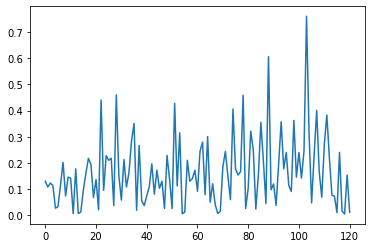

In [76]:
from sklearn.metrics import accuracy_score
x = np.linspace(0, len(y_pred)-1, 1)
diffList = diff.tolist()
diffList
plt.plot(diffList)

In [77]:
# from sklearn.decomposition import PCA
# pca=PCA(n_components=5)
# pca.fit(x_test)
# x_test=pca.transform(x_test)

# pca.fit(x_train)
# x_train=pca.transform(x_train)
# #let's check the shape of X_pca array
# print("shape of X_pca", x_test.shape)

# import numpy as np
# import matplotlib.pyplot as plt

len(movieInfoNew)

604